In [1]:
import pandas as pd
from keras.models import load_model
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
pdg_dict={'p':2212,'mu-':13, 'gamma':22, 'pi0':111,'pi+':211, 'e':11 }
from joblib import dump, load
from sklearn.metrics import confusion_matrix
import warnings
import matplotlib.pyplot as plt
import itertools
warnings.filterwarnings('ignore')

C:\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def df2image(df_pixel_cols):
    image = df_pixel_cols.copy(deep=True)
    image= image.values.astype('float32')
    image=image/255.0
    image = image.reshape(image.shape[0], 28, 28,1)
    return image

In [3]:
df_1 = pd.read_csv('../Test/hit pixels/nue_test_hit_pixels.csv')
df_2 = pd.read_csv('../Test/hit pixels/mu_test_hit_pixels.csv')
track_shower_df = pd.concat([df_1,df_2], ignore_index=True)

In [4]:
particle_df = pd.read_csv('../Test/energy pixels/mu_test_energy_smeared_version_3.csv')

In [5]:
track_df = particle_df[ (particle_df.pdg==211) | (particle_df.pdg==13) | (particle_df.pdg==2212) ]
track_df['target']=0
track_df['target']=np.where(track_df.pdg==211,2,np.where(track_df.pdg==13,1,0))
shower_df = particle_df[ (particle_df.pdg==11) | (particle_df.pdg==22)]
shower_df['target']=0
shower_df['target']= np.where(shower_df.pdg==11, 0, 1)

In [21]:
model = load_model('../Models/track_shower_model.h5')
bdt_model=load('../Models/track_shower_decision_tree.joblib' )
e_gamma_model = load_model('../Models/electron_gamma_model.h5')
p_mu_pi_model=load_model('../Models/proton_muon_pion_model.h5')

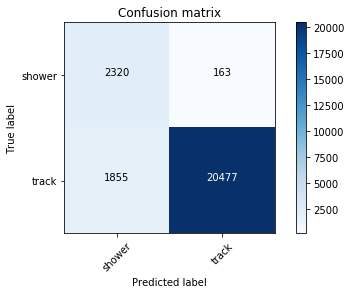

In [15]:
variables = ['eps','RSS', 'envelope', 'sliding']
bdt_pred = bdt_model.predict(track_shower_df[variables])
track_shower_df['bdt_pred'] = bdt_pred
confusion_mtx = confusion_matrix(track_shower_df['isTrueTrack'] , bdt_pred) 
plot_confusion_matrix(confusion_mtx, classes = ['shower','track'])
plt.show()

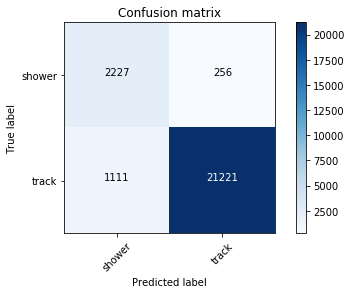

In [16]:
pixel_cols=[str(i) for i in range(28*28)]

cnn_pred_classes = model.predict(df2image(track_shower_df[pixel_cols]))
cnn_pred= np.argmax(cnn_pred_classes, axis = 1)
track_shower_df['cnn_pred'] = cnn_pred
confusion_mtx = confusion_matrix(track_shower_df['isTrueTrack'] , cnn_pred) 
plot_confusion_matrix(confusion_mtx, classes = ['shower','track'])
plt.show()

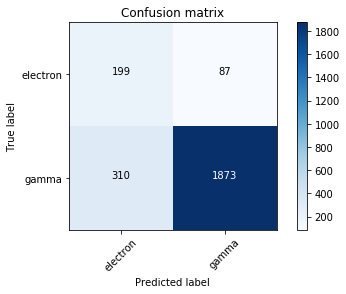

In [14]:
cnn_pred_classes = e_gamma_model.predict(df2image(shower_df[pixel_cols]))
cnn_pred= np.argmax(cnn_pred_classes, axis = 1)
confusion_mtx = confusion_matrix(shower_df['target'] , cnn_pred) 
plot_confusion_matrix(confusion_mtx, classes = ['electron', 'gamma'])
plt.show()

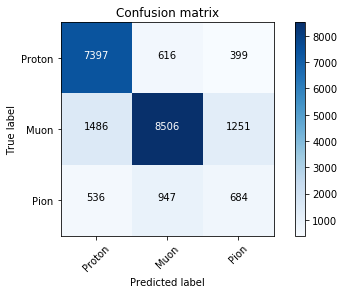

In [17]:
cnn_pred_classes = p_mu_pi_model.predict(df2image(track_df[pixel_cols]))
cnn_pred= np.argmax(cnn_pred_classes, axis = 1)
confusion_mtx = confusion_matrix(track_df['target'] , cnn_pred) 
plot_confusion_matrix(confusion_mtx, classes = ['Proton','Muon', 'Pion'])
plt.show()

In [18]:
tracks=['mu-', 'p', 'pi+']
showers=['e', 'gamma']
true_track_shower_df = track_shower_df[track_shower_df.isTrueTrack==track_shower_df.cnn_pred]
true_particle_df = particle_df.loc[true_track_shower_df.index]
true_particle_shower_df = true_particle_df[(true_particle_df.pdg==11)|(true_particle_df.pdg==22)]
true_particle_shower_df['target']=0
true_particle_shower_df['target']= np.where(true_particle_shower_df.pdg==11, 0, 1)
true_particle_track_df = true_particle_df[(true_particle_df.pdg==211)|(true_particle_df.pdg==2212)|(true_particle_df.pdg==13)]
true_particle_track_df['target']=0
true_particle_track_df['target']=np.where(true_particle_track_df.pdg==211,2,np.where(true_particle_track_df.pdg==13,1,0))

In [19]:
cnn_pred_classes = e_gamma_model.predict(df2image(true_particle_shower_df[pixel_cols]))
cnn_pred= np.argmax(cnn_pred_classes, axis = 1)
true_particle_shower_df['cnn_pred'] = cnn_pred
gamma_accuracy = len(true_particle_shower_df[(true_particle_shower_df.target==true_particle_shower_df.cnn_pred) & (true_particle_shower_df.target==1)])/len(track_shower_df[track_shower_df.pdg==22])
electron_accuracy = len(true_particle_shower_df[(true_particle_shower_df.target==true_particle_shower_df.cnn_pred) & (true_particle_shower_df.target==0)])/len(track_shower_df[track_shower_df.pdg==11])
print('gamma efficiency: '+ str(round(gamma_accuracy*100,1))+ '%')
print('electron efficiency: '+ str(round(electron_accuracy*100,1))+ '%')

gamma efficiency: 80.5%
electron efficiency: 64.3%


In [20]:
cnn_pred_classes = p_mu_pi_model.predict(df2image(true_particle_track_df[pixel_cols]))
cnn_pred= np.argmax(cnn_pred_classes, axis = 1)
true_particle_track_df['cnn_pred'] = cnn_pred
muon_accuracy = len(true_particle_track_df[(true_particle_track_df.target==true_particle_track_df.cnn_pred) & (true_particle_track_df.target==1)])/len(track_shower_df[track_shower_df.pdg==13])
pion_accuracy = len(true_particle_track_df[(true_particle_track_df.target==true_particle_track_df.cnn_pred) & (true_particle_track_df.target==2)])/len(track_shower_df[track_shower_df.pdg==211])
proton_accuracy = len(true_particle_track_df[(true_particle_track_df.target==true_particle_track_df.cnn_pred) & (true_particle_track_df.target==0)])/len(track_shower_df[track_shower_df.pdg==2212])

print('muon efficiency: '+ str(round(muon_accuracy*100,1))+ '%')
print('proton efficiency: '+ str(round(proton_accuracy*100,1))+ '%')
print('pion efficiency: '+ str(round(pion_accuracy*100,1))+ '%')

muon efficiency: 71.6%
proton efficiency: 82.9%
pion efficiency: 30.1%
